# Predicting Prior Authorization Outcomes to Optimize Manual Review

Author: Samuel Cooley

Date Started: 11/01/2025

# Background:

## Project Overview

This notebook walks through the full process of building a model that predicts which prior authorization requests are very likely to be approved. The idea is to find the straightforward cases that almost always get approved so they can skip manual review. That frees up reviewers to spend their time on the requests that really need attention.

### Data Summary
There are two small, de-identified tables in this case study:

- **PriorAuth** contains one row per authorization request with basic details and the final decision.
- **Claims** contains past paid claims with dates, services, and paid amounts.

When creating features, only the information that would have been known at the time of submission is used. This avoids peeking into the future and keeps the model honest.

### Modeling Steps
1. Link prior authorization records to relevant past claims based on what was available on the submission date.
2. Create simple history features, such as how many claims the pet had before, how much had been paid, and how long it had been since the last claim.
3. Keep only requests that went through manual review and were either approved or denied.
4. Train three models: Logistic Regression, Random Forest, and XGBoost.
5. Tune and calibrate the Random Forest and choose a threshold that favors precision so that false approvals stay low.
6. Evaluate the models and look at results by service type to understand where automation is reliable.

### Key Results
- The Random Forest model performed the best on the test set with an AUC of 0.844.
- With a threshold of 0.60, precision is about 0.90 and recall about 0.73.
- About half of the manual-review cases can be safely automated at that threshold.
- Cross validation for the Random Forest showed an average AUC of 0.872 with low variation across folds.
- Check-Up services are extremely predictable, while X-Rays show more mixed results.

This notebook focuses on the code, feature engineering, and detailed evaluation that support these findings.

---
### **Business Problems Addressed**  
1. **Reduce manual review volume while maintaining accuracy.**  
   - Track precision at the selected threshold and the share of manual cases automatically approved.  

2. **Improve provider workflow and feedback loops.**  
   - Measure provider-level approval rates to identify policy or training gaps.  

3. **Refine service-level policies.**  
   - Highlight services that are routinely approved and suitable for automation, while flagging those that still need manual oversight.  

4. **Enhance turnaround time and member experience.**  
   - Increase the share of instant approvals to reduce delays and minimize care leakage.

---

# (0) - Import Step

In [8]:
# =============================================================================
# A.) Preload Packages
# =============================================================================
import os
os.environ["MKL_SERVICE_FORCE_INTEL"] = "1"
os.environ["MKL_DEBUG_CPU_TYPE"] = "5"
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from sklearn.calibration import CalibratedClassifierCV
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    RocCurveDisplay, PrecisionRecallDisplay, precision_score, recall_score
)
from sklearn.model_selection import (
    RandomizedSearchCV, StratifiedKFold, cross_val_score, train_test_split
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.utils.class_weight import compute_class_weight

from xgboost import XGBClassifier

sns.set_context("notebook")


In [9]:
# =============================================================================
# B.) Preliminary Functions
# =============================================================================


def fn_smry_df(df):
    """
    Parameters
    ----------
    df : Raw Input Data

    Returns
    -------
    Prints summary of data frame
    """
    print(f"Number of Rows: {df.shape[0]}")
    print(f"Number of Columns: {df.shape[1]}")
    print()
    print(f"Columns:\n{df.columns.tolist()}")
    print()
    print(f"Data Types:\n{df.dtypes}")
    print()
    print(f"Summary Statistics:\n{df.describe()}")
    print()
    print(f"Missing Values:\n{df.isna().sum()}") 



def clean_names(df): 
    """
    Parameters
    ----------
    df : Raw Input Data

    Returns
    -------
    df : Lowercase, clean column names
    """
    cln_cols = [col.lower() for col in df.columns]
    cln_cols = [col.replace(' ', '_') for col in cln_cols]
    cln_cols = [''.join(char if char.isalnum() or char == '_' else '_' for char in col) for col in cln_cols]
    cln_cols = ['_'.join(filter(None, col.split('_'))).rstrip('_') for col in cln_cols]
    df.columns = cln_cols
    return df

In [10]:
# =============================================================================
# C.) Raw Data
# =============================================================================

raw_PriorAuth = pd.read_excel('Data/PriorAuth.xlsx')
raw_Claims = pd.read_excel('Data/Claims.xlsx')

# (1) - EDA (PriorAuth)

In [12]:
cln_PriorAuth = clean_names(raw_PriorAuth)

fn_smry_df(cln_PriorAuth)
print(cln_PriorAuth.head())


Number of Rows: 2000
Number of Columns: 10

Columns:
['id', 'pat_name', 'service', 'submission_date', 'provider_id', 'unit', 'authstatus', 'auto_approved', 'clinical_reviewer', 'pat_id']

Data Types:
id                           object
pat_name                     object
service                      object
submission_date      datetime64[ns]
provider_id                   int64
unit                          int64
authstatus                   object
auto_approved                  bool
clinical_reviewer            object
pat_id                       object
dtype: object

Summary Statistics:
       provider_id         unit
count  2000.000000  2000.000000
mean   1010.202000     1.517000
std       6.119307     0.857367
min    1000.000000     1.000000
25%    1005.000000     1.000000
50%    1010.000000     1.000000
75%    1016.000000     2.000000
max    1020.000000     4.000000

Missing Values:
id                      0
pat_name                0
service                 0
submission_date       

In [13]:
# Cleaning: normalize join keys 
cln_PriorAuth['pat_id']= cln_PriorAuth['pat_id'].astype(str).str.upper().str.strip()
cln_PriorAuth['service'] = cln_PriorAuth['service'].astype(str).str.strip().str.title()


# Month-year helpers + totals
cln_PriorAuth['submission_month_year'] = cln_PriorAuth['submission_date'].dt.strftime("%Y-%m")
cln_PriorAuth['submission_year']  = cln_PriorAuth['submission_date'].dt.year
cln_PriorAuth['cts_claims'] = cln_PriorAuth.groupby('submission_month_year')['unit'].transform('sum')

# Check uniqueness
print(f"Is ID unique? {cln_PriorAuth.id.nunique() == cln_PriorAuth.shape[0]}")
print()
print(f"Is Patient ID unique? {cln_PriorAuth.pat_id.nunique() == cln_PriorAuth.shape[0]}")

Is ID unique? True

Is Patient ID unique? False


- Data is at the the procedure-approval level, where each observational unit represents if a claim/service
   was approved or not, rolled up by counts

In [15]:
# Review Missing Data
pct_missing_reviewers = cln_PriorAuth['clinical_reviewer'].isna().sum() / len(cln_PriorAuth) * 100
print(f"Clinical Reviwers are missing for roughly {pct_missing_reviewers:.1f}% of total authorizations")
print()
print(f"How many clinical reviewers?: {cln_PriorAuth.clinical_reviewer.nunique()}")

#Check Service types
print("Service Tabulation Counts:\n")
print(cln_PriorAuth['service'].value_counts())

Clinical Reviwers are missing for roughly 69.4% of total authorizations

How many clinical reviewers?: 40
Service Tabulation Counts:

Check-Up           590
X-Ray              394
Vaccination        327
Dental Cleaning    288
Surgery            224
Lab Test           177
Name: service, dtype: int64


<Figure size 800x400 with 0 Axes>

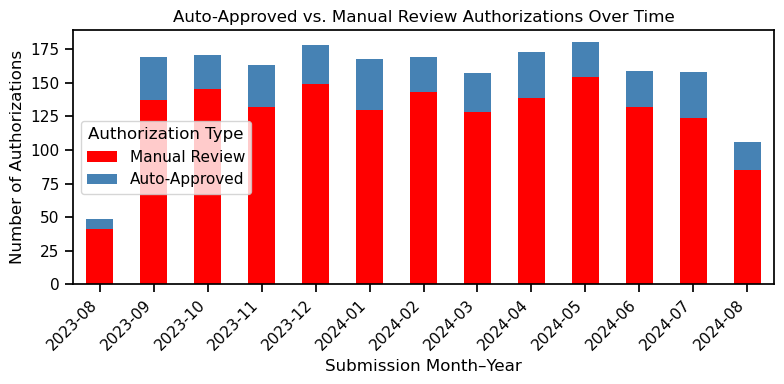

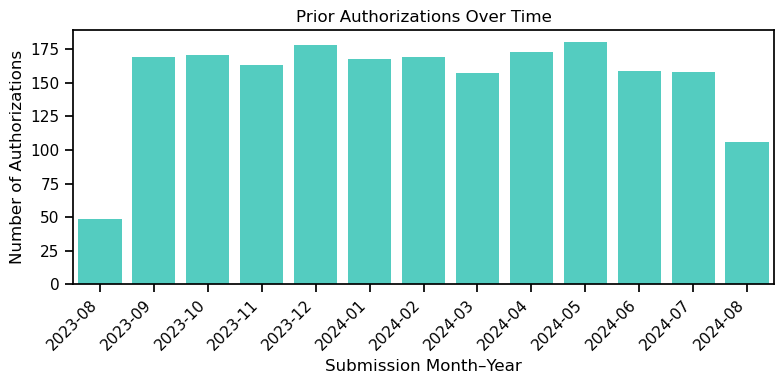

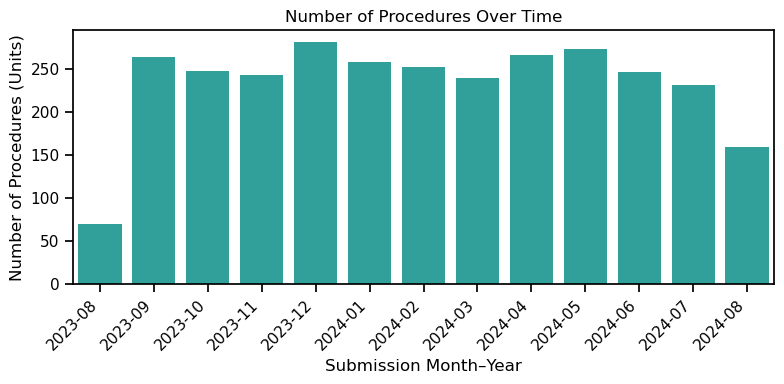

In [16]:
# =============================================================================
# PriorAuth Visuals
# =============================================================================

# Auto-Approved vs Manual over time
stack_data = (
    cln_PriorAuth
    .groupby(['submission_month_year', 'auto_approved'])
    .size()
    .unstack(fill_value=0)
    .sort_index()
)

plt.figure(figsize=(8,4))
stack_data.plot(kind='bar', stacked=True, color=['red', 'steelblue'], figsize=(8,4))
plt.title("Auto-Approved vs. Manual Review Authorizations Over Time")
plt.xlabel("Submission Month–Year")
plt.ylabel("Number of Authorizations")
plt.xticks(rotation=45, ha='right')
plt.legend(["Manual Review", "Auto-Approved"], title="Authorization Type")
plt.tight_layout()
plt.show()

# Authorizations over time
plt.figure(figsize=(8,4))
sns.countplot(
    data=cln_PriorAuth.sort_values(by='submission_month_year'),
    x='submission_month_year',
    color='#40E0D0'
)
plt.title("Prior Authorizations Over Time")
plt.xlabel("Submission Month–Year")
plt.ylabel("Number of Authorizations")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Total Procedures by month-year
plt.figure(figsize=(8,4))
sns.barplot(
    data=cln_PriorAuth.sort_values(by='submission_month_year'),
    x='submission_month_year',
    y='cts_claims',
    color='#20B2AA'
)
plt.title("Number of Procedures Over Time")
plt.xlabel("Submission Month–Year")
plt.ylabel("Number of Procedures (Units)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [17]:
print(min(cln_PriorAuth.submission_date))
print(max(cln_PriorAuth.submission_date))

2023-08-20 14:26:19
2024-08-19 14:26:19


- The dataset does not cover a full month, spanning from 08/20/2023 to 08/19/2024. Otherwise, claim volumes appear consistent across months, with no evident data pull issues.
- The majority of claims undergo manual review, signals that current algorithm could be improved to auto-approve more claims and reduce admin burden.

<Figure size 1000x500 with 0 Axes>

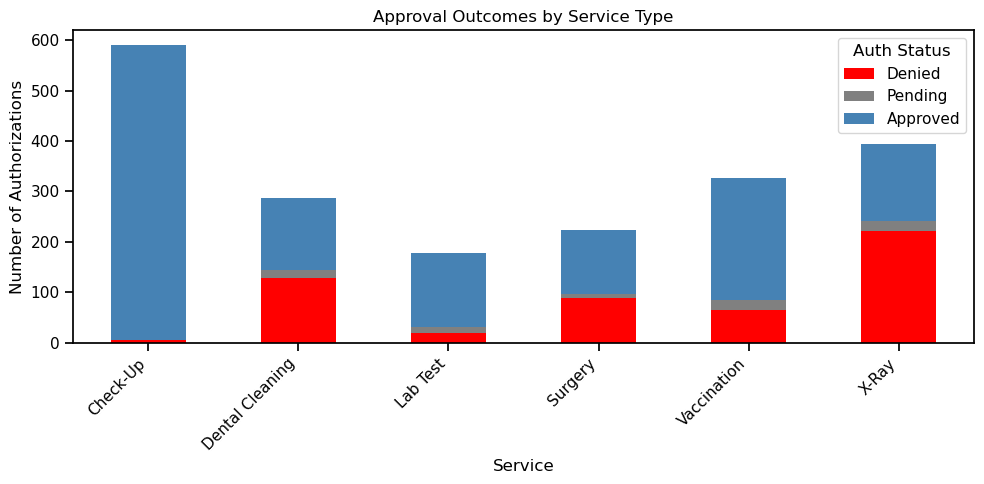

<Figure size 1000x500 with 0 Axes>

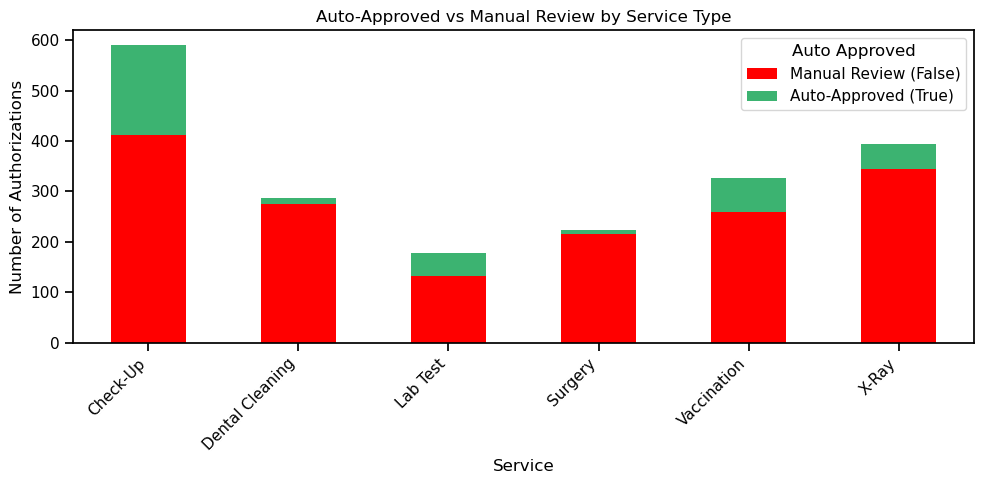

In [19]:
# Approval outcomes by service
service_stack = (
    cln_PriorAuth
    .groupby(['service', 'authstatus'])
    .size()
    .unstack(fill_value=0)
    .reindex(columns=['Denied', 'Pending', 'Approved'], fill_value=0)
)

plt.figure(figsize=(10,5))
service_stack.plot(
    kind='bar', stacked=True,
    color=['red', 'grey', 'steelblue'],
    figsize=(10,5)
)
plt.title("Approval Outcomes by Service Type")
plt.xlabel("Service")
plt.ylabel("Number of Authorizations")
plt.xticks(rotation=45, ha='right')
plt.legend(["Denied", "Pending", "Approved"], title="Auth Status")
plt.tight_layout()
plt.show()

# Auto vs Manual by service
auto_service = (
    cln_PriorAuth
    .groupby(['service', 'auto_approved'])
    .size()
    .unstack(fill_value=0)
    .reindex(columns=[False, True], fill_value=0)
)

plt.figure(figsize=(10,5))
auto_service.plot(
    kind='bar', stacked=True,
    color=['red', 'mediumseagreen'],
    figsize=(10,5)
)
plt.title("Auto-Approved vs Manual Review by Service Type")
plt.xlabel("Service")
plt.ylabel("Number of Authorizations")
plt.xticks(rotation=45, ha='right')
plt.legend(["Manual Review (False)", "Auto-Approved (True)"], title="Auto Approved")
plt.tight_layout()
plt.show()

- Status-quo review process clearly favors manual review, even though most claims end up getting approved anyways. Specific low-risk services such as check-ups, dental cleanings, lab tests, and vaccinations are prime candidates for automation; allowing manual reviewers to focus on higher risk services.

# (2) - EDA (Claims)

In [22]:
cln_Claims = clean_names(raw_Claims)


fn_smry_df(cln_Claims)
print(cln_Claims.head())

Number of Rows: 788
Number of Columns: 7

Columns:
['pat_name', 'provider_npi', 'claim_id', 'claim_type', 'amount_paid', 'pat_id', 'claim_date']

Data Types:
pat_name                object
provider_npi             int64
claim_id                object
claim_type              object
amount_paid            float64
pat_id                  object
claim_date      datetime64[ns]
dtype: object

Summary Statistics:
       provider_npi  amount_paid
count    788.000000   788.000000
mean    1010.357868   576.892335
std        6.060588  1006.383295
min     1000.000000    50.280000
25%     1005.000000   113.932500
50%     1010.000000   189.335000
75%     1016.000000   473.932500
max     1020.000000  4990.630000

Missing Values:
pat_name        0
provider_npi    0
claim_id        0
claim_type      0
amount_paid     0
pat_id          0
claim_date      0
dtype: int64
  pat_name  provider_npi  claim_id       claim_type  amount_paid    pat_id  \
0   Sophie          1008  1551DB6D         Check-up        

In [23]:
# normalize join keys early
cln_Claims['pat_id']   = cln_Claims['pat_id'].astype(str).str.upper().str.strip()
cln_Claims = cln_Claims.rename(columns={'claim_type':'service'})
cln_Claims['service'] = cln_Claims['service'].astype(str).str.strip().str.title()



# Month-year helpers + totals
cln_Claims['claim_month_year'] = cln_Claims['claim_date'].dt.strftime("%Y-%m")

In [24]:
print(min(cln_Claims.claim_date))
print(max(cln_Claims.claim_date))

2021-08-26 14:26:19
2023-11-04 14:26:19


- Claims table covers August 2021 through November 2023. Because of this, it won’t align one-to-one with every prior authorization record. Only authorizations submitted between August and November 2023 will have a full claims history with completed payments and final approval outcomes.

In [26]:
#Check for uniqueness of ID variables, Data is from the time period mentioned
print(f"Is Claim ID unique? {cln_Claims.claim_id.nunique() == cln_Claims.shape[0]}")

Is Claim ID unique? True


- Claim IDs are unique, so there are no duplicates.
- The payment field also contains no negative or zero values, which would typically indicate reversals or adjustments. This means the data is already at the individual procedure level with final paid amounts, and no additional aggregation is needed as would be required with raw claims data.


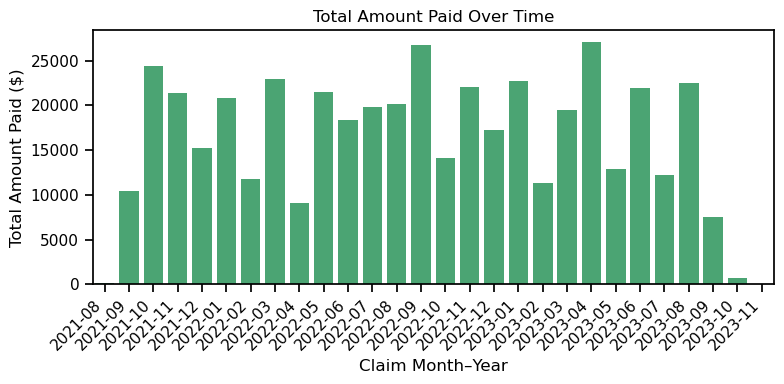

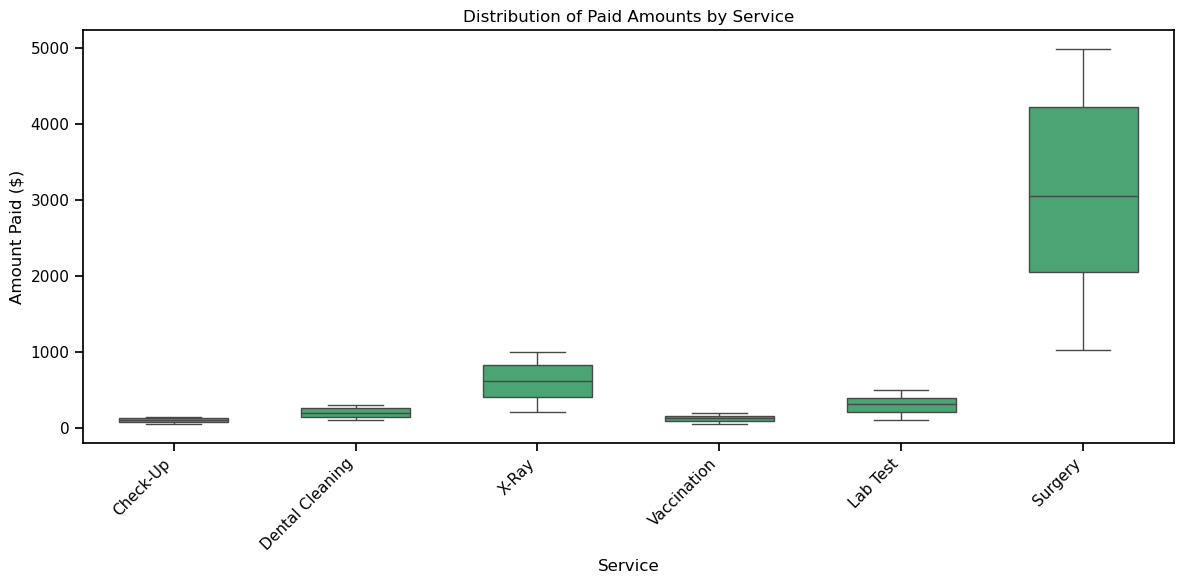


Mean vs Median for Payments by Service Type

                        mean       50%
service                               
Check-Up          101.012941   102.200
Dental Cleaning   200.248321   197.860
Lab Test          304.125833   310.095
Surgery          3118.090230  3060.330
Vaccination       124.767745   126.525
X-Ray             614.824702   614.440

Note: Large variation in Surgery payments (wide IQR), consistent with real-world expectations.


In [28]:
# =============================================================================
# Claims Visuals
# =============================================================================

paid_by_month = (
    cln_Claims
    .groupby('claim_month_year', as_index=False)['amount_paid']
    .sum()
)

plt.figure(figsize=(8,4))
sns.barplot(
    data=paid_by_month,
    x='claim_month_year',
    y='amount_paid',
    color='mediumseagreen'
)
plt.title("Total Amount Paid Over Time")
plt.xlabel("Claim Month–Year")
plt.ylabel("Total Amount Paid ($)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 2. Paid Amounts by Service (Box Plot)
plt.figure(figsize=(12,6))
sns.boxplot(
    data=cln_Claims,
    x='service',
    y='amount_paid',
    color='mediumseagreen',
    width=0.6,
    fliersize=4
)
plt.title("Distribution of Paid Amounts by Service")
plt.xlabel("Service")
plt.ylabel("Amount Paid ($)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Summary stats: Mean vs Median
svc_tbl = cln_Claims.groupby('service')['amount_paid'].describe()[['mean', '50%']]
print("\nMean vs Median for Payments by Service Type\n")
print(svc_tbl)
print("\nNote: Large variation in Surgery payments (wide IQR), consistent with real-world expectations.")

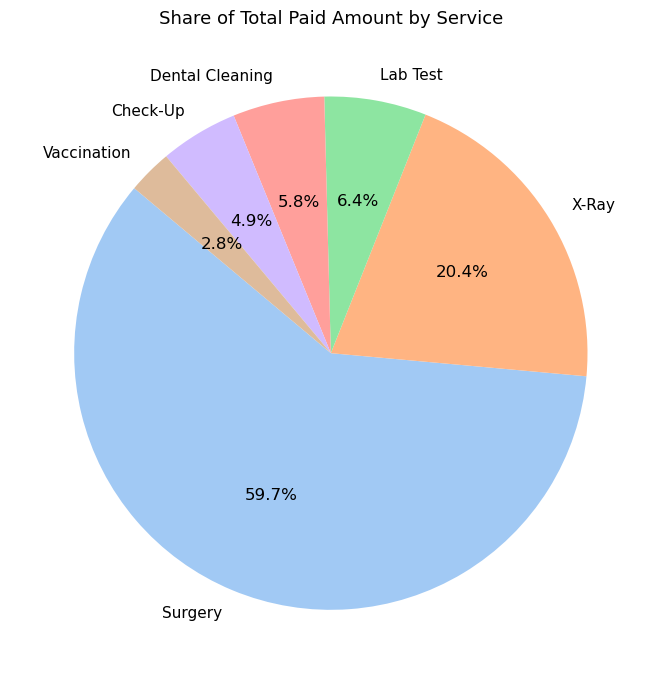

Share of Total Paid Amount by Service:

           service  amount_paid  pct_share
3          Surgery    271273.85  59.674247
5            X-Ray     92838.53  20.422423
2         Lab Test     29196.08   6.422492
1  Dental Cleaning     26232.53   5.770576
0         Check-Up     22323.86   4.910755
4      Vaccination     12726.31   2.799507


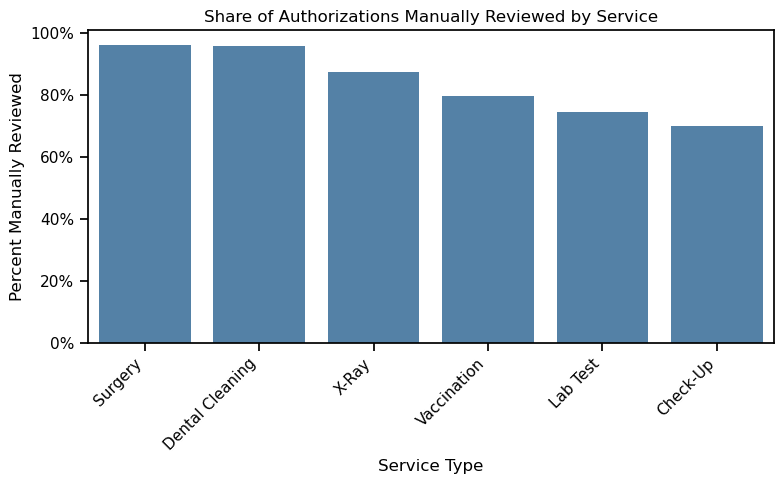

In [29]:
svc_share = (
    cln_Claims
    .groupby('service', as_index=False)['amount_paid']
    .sum()
    .sort_values('amount_paid', ascending=False)
)
svc_share['pct_share'] = 100 * svc_share['amount_paid'] / svc_share['amount_paid'].sum()

plt.figure(figsize=(7,7))
plt.pie(
    svc_share['amount_paid'],
    labels=svc_share['service'],
    autopct='%1.1f%%',
    startangle=140,
    colors=sns.color_palette("pastel", n_colors=len(svc_share))
)
plt.title("Share of Total Paid Amount by Service", fontsize=13)
plt.tight_layout()
plt.show()

print("Share of Total Paid Amount by Service:\n")
print(svc_share[['service', 'amount_paid', 'pct_share']])

# Share of Manual Reviews by Service
manual_share = (
    cln_PriorAuth
    .groupby('service')['auto_approved']
    .value_counts(normalize=True)
    .rename('pct')
    .reset_index()
)
manual_share = manual_share[manual_share['auto_approved'] == False].sort_values('pct', ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(data=manual_share, x='service', y='pct', color='steelblue')
plt.title("Share of Authorizations Manually Reviewed by Service")
plt.xlabel("Service Type")
plt.ylabel("Percent Manually Reviewed")
plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter(1.0))
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Observed Patterns

- **Surgeries**
  - Highest payment amounts and a large share of manual reviews, but most are eventually approved.
  - Streamlining prior authorization for common surgeries could reduce administrative work.
  - More detail on revenue codes or admission type could help flag unnecessary procedures.

- **X-Rays**
  - About 20% of total payments, second only to surgery.
  - Low-risk and typically approved, yet often sent for manual review.
  - Good target for automation or simpler approval rules.



In [31]:
# =============================================================================
# Outlier Detection for Paid Amounts
# =============================================================================

# Do this by service to control for differences in payment distributions 
# (e.g., surgeries will naturally have higher costs than X-rays or check-ups)

Q1 = cln_Claims.groupby('service')['amount_paid'].quantile(0.25)
Q3 = cln_Claims.groupby('service')['amount_paid'].quantile(0.75)
IQR = Q3 - Q1

cln_Claims['flag_outlier_amount_paid'] = (
    (cln_Claims['amount_paid'] < (cln_Claims['service'].map(Q1 - 1.5 * IQR))) |
    (cln_Claims['amount_paid'] > (cln_Claims['service'].map(Q3 + 1.5 * IQR)))
)

print("Outlier Flag Results:\n")
print(cln_Claims.flag_outlier_amount_paid.value_counts(dropna=False))

# In this small case-study dataset, no paid-amount outliers were flagged by the IQR rule.
# Real claims data is usually more right-skewed, so this is more of a convenience than a general rule.


Outlier Flag Results:

False    788
Name: flag_outlier_amount_paid, dtype: int64


# (3) - Data Wrangling (Merge, Final Sanity Checks)

## Building Submission-Time History from Claims


Instead of trying to force a direct one-to-one join, I built the historical view explicitly.  
Here, **we treat the priorAuth as the universe of all claims**, and then attach whatever past information we can recover from the claims table.

The steps look like this:

1. **Create a unique `row_id`** for every authorization so I can always aggregate back to a single row per request.  
2. **Merge authorizations and claims on `pat_id`** to capture any related claims.  
3. **Keep only the claims that occurred on or before the submission date** (`claim_date <= submission_date`) to avoid any future information slipping through.  
4. **Aggregate by `row_id`** to build the history for each request:  
   - the most recent claim date  
   - how many prior claims exist  
   - the total amount paid on those claims  
5. **Compute derived fields**, such as days since the last claim and the average paid per claim, and fill in reasonable defaults for members with no history.  
6. Remove helper columns and double-check that time-based values are all non-negative.

---

### Why this approach works:

This method avoids dropping valid records, respects the timeline for every request, and makes sure the model only sees data that would have been available at submission. It also produces clean, intuitive features that match how someone reviewing an authorization would actually think about prior utilization.

In [34]:
# (1) Add a stable row_id to PriorAuth to aggregate back cleanly
cln_PriorAuth = cln_PriorAuth.reset_index(drop=True)
cln_PriorAuth['row_id'] = cln_PriorAuth.index

# (2) Join on pat_id only to capture any-service history
pa_keys = cln_PriorAuth[['row_id', 'pat_id', 'submission_date']].copy()

merged = pa_keys.merge(
    cln_Claims[['pat_id', 'claim_date', 'amount_paid', 'claim_id']],
    on='pat_id',
    how='left'
)

# (3) Keep only claims on or before submission date → prevents label leakage
prior_only = merged[merged['claim_date'] <= merged['submission_date']].copy()

# (4) Aggregate per authorization row_id
agg = (
    prior_only
    .groupby('row_id', as_index=False)
    .agg(
        last_claim_date      = ('claim_date', 'max'),
        total_prior_claims   = ('claim_id', 'count'),
        total_prior_paid     = ('amount_paid', 'sum')
    )
)

# (5) Join aggregates back to PriorAuth and finish features
cln_PriorAuth = cln_PriorAuth.merge(agg, on='row_id', how='left')

cln_PriorAuth['days_since_last_claim'] = (
    cln_PriorAuth['submission_date'] - cln_PriorAuth['last_claim_date']
).dt.days

# (6) Sensible defaults (no history)
cln_PriorAuth['total_prior_claims']    = cln_PriorAuth['total_prior_claims'].fillna(0).astype(int)
cln_PriorAuth['total_prior_paid']      = cln_PriorAuth['total_prior_paid'].fillna(0.0)
cln_PriorAuth['days_since_last_claim'] = cln_PriorAuth['days_since_last_claim'].fillna(9999)

# Quick sanity check: no negative recency when there is history
mask = cln_PriorAuth['total_prior_claims'] > 0
assert (cln_PriorAuth.loc[mask, 'days_since_last_claim'] >= 0).all()

# Tidy up helper column
cln_PriorAuth.drop(columns=['row_id'], inplace=True)

In [35]:
#Inspect Merged Data
fn_smry_df(cln_PriorAuth)
print(cln_PriorAuth.head())

Number of Rows: 2000
Number of Columns: 17

Columns:
['id', 'pat_name', 'service', 'submission_date', 'provider_id', 'unit', 'authstatus', 'auto_approved', 'clinical_reviewer', 'pat_id', 'submission_month_year', 'submission_year', 'cts_claims', 'last_claim_date', 'total_prior_claims', 'total_prior_paid', 'days_since_last_claim']

Data Types:
id                               object
pat_name                         object
service                          object
submission_date          datetime64[ns]
provider_id                       int64
unit                              int64
authstatus                       object
auto_approved                      bool
clinical_reviewer                object
pat_id                           object
submission_month_year            object
submission_year                   int64
cts_claims                        int64
last_claim_date          datetime64[ns]
total_prior_claims                int64
total_prior_paid                float64
days_since_last_

# (4) - Predictive Modeling

**Outline:**
- Predict approval only for cases not already auto-approved. We'll also drop pending claims.
- Use submission time info only; claims are prior history aggregates (no leakage).

**Upgrades in this block:**
1) Class imbalance: apply `class_weight='balanced'` (and XGBoost `scale_pos_weight`).
2) Compact features: `avg_paid_per_claim`, `provider_volume`, and a provider-rate × pet-count interaction.
3) Random Forest: small randomized search (AUC) to find best pipeline; then isotonic calibration for better thresholding.
4) XGBoost: strong tabular baseline; compute AUC and probabilities for later comparison.

**Outputs kept for section (5):**
- `y_pred_log` / `y_proba_log`  (Logistic Regression)
- `y_pred_rf`  / `y_proba_rf`    (calibrated tuned Random Forest)
- `log_pipe`, `rf_pipe`          (`rf_pipe` used for feature importances)
- `y_pred_xgb` / `y_proba_xgb`

In [38]:
# =============================================================================
# Cohort & target variable
# =============================================================================
mdl_df = cln_PriorAuth.copy()
mdl_df = mdl_df[mdl_df['auto_approved'] == False].copy()
mdl_df['authstatus_norm'] = mdl_df['authstatus'].astype(str).str.strip().str.title()
mdl_df = mdl_df[mdl_df['authstatus_norm'].isin(['Approved', 'Denied'])].copy()
y = (mdl_df['authstatus_norm'] == 'Approved').astype(int)

print("Manual-review cohort size:", len(mdl_df))
print("Target distribution:\n", y.value_counts())

Manual-review cohort size: 1563
Target distribution:
 1    1035
0     528
Name: authstatus_norm, dtype: int64


- authstatus is moderately imbalanced (roughly 66% approved vs 34% denied). 
- We'll apply class weights and use stratified splits to ensure balanced representation during training.
- Pending status authorizations were excluded from training to avoid ambiguous labels.
- Assumes provider behavior and service mix remain stable between 2023 and 2024

In [40]:
# =============================================================================
# Submission-time features
# =============================================================================
mdl_df['submission_year']  = mdl_df['submission_date'].dt.year
mdl_df['submission_month'] = mdl_df['submission_date'].dt.month
mdl_df['submission_dow']   = mdl_df['submission_date'].dt.dayofweek

# per-pet prior volume (engagement/complexity proxy)
mdl_df['pat_auth_count'] = mdl_df.groupby('pat_id')['pat_id'].transform('count')

# prior-history fills (from earlier merge)
for col, val in [('total_prior_claims', 0), ('total_prior_paid', 0.0)]:
    if col in mdl_df.columns:
        mdl_df[col] = mdl_df[col].fillna(val)
if 'days_since_last_claim' in mdl_df.columns:
    mdl_df['days_since_last_claim'] = mdl_df['days_since_last_claim'].fillna(9999).clip(lower=0)

# compact extras that often help tabular learners
mdl_df['avg_paid_per_claim'] = mdl_df['total_prior_paid'] / (mdl_df['total_prior_claims'] + 1e-6)
mdl_df['provider_volume']    = mdl_df.groupby('provider_id')['provider_id'].transform('count')

# --- Feature set --------------------------------------------------------------
base_features = [
    'service','provider_id','unit',
    'submission_year','submission_month','submission_dow',
    'pat_auth_count','total_prior_claims','total_prior_paid','days_since_last_claim',
    'avg_paid_per_claim','provider_volume'
]
drop_if_present = [
    'authstatus','authstatus_norm','auto_approved','clinical_reviewer','id',
    'pat_name','submission_date','submission_month_year','cts_claims','last_claim_date'
]
X_all = mdl_df.drop(columns=[c for c in drop_if_present if c in mdl_df.columns], errors='ignore')
feature_cols = [c for c in base_features if c in X_all.columns]
X_all = X_all[feature_cols].copy()
print("Features used:", X_all.columns.tolist())

Features used: ['service', 'provider_id', 'unit', 'submission_year', 'submission_month', 'submission_dow', 'pat_auth_count', 'total_prior_claims', 'total_prior_paid', 'days_since_last_claim', 'avg_paid_per_claim', 'provider_volume']


In [41]:
# =============================================================================
# Split
# =============================================================================


X_train, X_test, y_train, y_test = train_test_split(X_all, y, test_size=0.20, random_state=42, stratify=y)


# =============================================================================
# Non-leaky provider approval rate (TRAIN-only) + interaction
# =============================================================================


tmp = pd.DataFrame({'provider_id': mdl_df.loc[X_train.index, 'provider_id'], 'y': y_train})

prov_rate = tmp.groupby('provider_id')['y'].mean().rename('provider_approval_rate')
global_rate = y_train.mean()

X_train['provider_approval_rate'] = X_train['provider_id'].map(prov_rate).fillna(global_rate)
X_test['provider_approval_rate']  = X_test['provider_id'].map(prov_rate).fillna(global_rate)

X_train['provider_rate_x_patcount'] = X_train['provider_approval_rate'] * X_train['pat_auth_count']
X_test['provider_rate_x_patcount']  = X_test['provider_approval_rate']  * X_test['pat_auth_count']

# update lists
cat_cols = [c for c in X_train.columns if X_train[c].dtype == 'object']
num_cols = [c for c in X_train.columns if c not in cat_cols]

# =============================================================================
# Preprocessing 
# =============================================================================

pre = ColumnTransformer([
    ('cat', Pipeline([
        ('impute', SimpleImputer(strategy='most_frequent')),
        ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False)),
    ]), cat_cols),
    ('num', Pipeline([
        ('impute', SimpleImputer(strategy='median')),
        ('scale', StandardScaler()),
    ]), num_cols)
], remainder='drop')

In [42]:
# =============================================================================
# Class imbalance weights
# =============================================================================
cls_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
weights = dict(zip(np.unique(y_train), cls_weights))
print("Class weights:", weights)

Class weights: {0: 1.481042654028436, 1: 0.7548309178743962}


- The computed class weights assign higher importance to the minority (Denied) class. 
- This helps the model pay more attention to underrepresented outcomes and avoid bias toward approvals.

In [44]:
# =============================================================================
# Baselines: Logistic Regression & RF
# =============================================================================
log_pipe = Pipeline([
    ('pre', pre),
    ('clf', LogisticRegression(max_iter=400, class_weight=weights))
])

rf_pipe = Pipeline([
    ('pre', pre),
    ('clf', RandomForestClassifier(
        n_estimators=400,
        random_state=42,
        class_weight=weights))
])


#Fit models
log_pipe.fit(X_train, y_train)
rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['service']),
                                                 ('num',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['provider_id', 'unit',
                                                   'submission_year',
                                                   'submission_month',
                                                   'submission_dow',
                                                   'pat_auth_count',
                                                   'total_prior_claims',
                                                   'total_prior_paid',
                                                   'days_since_last_claim',
                                                   'avg_paid_per_claim',
                                                   'provider_volume',
                                                   'provider_approval_rate',
                                                   'provider_rate_x_patcount'])])),
                ('clf',
                 RandomForestClassifier(class_weight={0: 1.481042654028436,
                                                      1: 0.7548309178743962},
                                        n_estimators=400, random_state=42))])

In [103]:
# =============================================================================
# Tune Random Forest for AUC, then calibrate for better thresholding
# =============================================================================
param_grid = {
    'clf__n_estimators': [300, 400, 600, 800],
    'clf__max_depth': [None, 10, 15, 20],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 2, 4],
    'clf__max_features': ['sqrt', 'log2'],
}
search = RandomizedSearchCV(
    rf_pipe,
    param_distributions=param_grid,
    n_iter=25,
    scoring='roc_auc',
    n_jobs=-1,
    cv=5,
    verbose=0,
    random_state=42
)
search.fit(X_train, y_train)
rf_pipe = search.best_estimator_ 
print("Best RF params:", search.best_params_)

rf_cal = CalibratedClassifierCV(rf_pipe, method='isotonic', cv=3)
rf_cal.fit(X_train, y_train)

Best RF params: {'clf__n_estimators': 600, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 1, 'clf__max_features': 'log2', 'clf__max_depth': None}


CalibratedClassifierCV(cv=3,
                       estimator=Pipeline(steps=[('pre',
                                                  ColumnTransformer(transformers=[('cat',
                                                                                   Pipeline(steps=[('impute',
                                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                                   ('ohe',
                                                                                                    OneHotEncoder(handle_unknown='ignore',
                                                                                                                  sparse_output=False))]),
                                                                                   ['service']),
                                                                                  ('num',
                                                                                   Pipeline(steps=[('impute',
                                                                                                    SimpleImputer(strategy='median')),
                                                                                                   ('scale',
                                                                                                    StandardScaler())]),
                                                                                   ['pro...
                                                                                    'pat_auth_count',
                                                                                    'total_prior_claims',
                                                                                    'total_prior_paid',
                                                                                    'days_since_last_claim',
                                                                                    'avg_paid_per_claim',
                                                                                    'provider_volume',
                                                                                    'provider_approval_rate',
                                                                                    'provider_rate_x_patcount'])])),
                                                 ('clf',
                                                  RandomForestClassifier(class_weight={0: 1.481042654028436,
                                                                                       1: 0.7548309178743962},
                                                                         max_features='log2',
                                                                         min_samples_split=5,
                                                                         n_estimators=600,
                                                                         random_state=42))]),
                       method='isotonic')

In [46]:
# =============================================================================
# XGBoost for validation
# =============================================================================
pos = y_train.sum()
neg = len(y_train) - pos
spw = neg / max(pos, 1)

xgb_pipe = Pipeline([
    ('pre', pre),
    ('clf', XGBClassifier(
        n_estimators=700,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric='auc',
        random_state=42,
        scale_pos_weight=spw
    ))
])

#Fit model
xgb_pipe.fit(X_train, y_train)

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['service']),
                                                 ('num',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['provider_id', 'unit',
                                                   'submission_year',
                                                   'su...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=700, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [47]:
# =============================================================================
# Probabilities & labels 
# =============================================================================
y_proba_log = log_pipe.predict_proba(X_test)[:, 1]
y_pred_log  = (y_proba_log >= 0.5).astype(int)

# Use CALIBRATED RF for metrics/plots in, but retain rf_pipe for feature importances there.
y_proba_rf = rf_cal.predict_proba(X_test)[:, 1]
y_pred_rf  = (y_proba_rf >= 0.5).astype(int)

# Validation: XGBoost outputs
y_proba_xgb = xgb_pipe.predict_proba(X_test)[:, 1]
y_pred_xgb  = (y_proba_xgb >= 0.5).astype(int)

print("AUC (LogReg):", round(roc_auc_score(y_test, y_proba_log), 3))
print("AUC (RF tuned + calibrated):", round(roc_auc_score(y_test, y_proba_rf), 3))
print("AUC (XGBoost):", round(roc_auc_score(y_test, y_proba_xgb), 3))

AUC (LogReg): 0.807
AUC (RF tuned + calibrated): 0.844
AUC (XGBoost): 0.811


# (5) - Model Evaluation & Threshold Selection

We evaluate three models on the *held-out* test set:

- **Logistic Regression**: interpretable baseline, usually well-calibrated  
- **Random Forest (tuned + isotonic-calibrated)**: primary model for policy thresholding  
- **XGBoost**: strong tabular validation with class-imbalance weighting  

#### Why show three?

- Logistic Regression provides high interpretability and typically reliable probabilities.  
- The calibrated Random Forest serves as the main policy model, combining strong AUC with well-calibrated scores.  
- XGBoost offers a robustness check and can sometimes outperform RF on structured data.  

#### Key Metrics

- Use **ROC** and **Precision–Recall** curves to show ranking quality.  
- Use **confusion matrices** to illustrate outcomes at the default 0.50 cutoff.  
- Use a **threshold sweep** on calibrated RF probabilities to choose a precision-focused operating point. 

In [50]:
# =============================================================================
# Summary metrics (text)
# =============================================================================
print("==== Logistic Regression ====")
print(classification_report(y_test, y_pred_log, digits=3))
print("AUC (LogReg):", round(roc_auc_score(y_test, y_proba_log), 3))

print("\n==== Random Forest (tuned + calibrated) ====")
print(classification_report(y_test, y_pred_rf, digits=3))
print("AUC (RF calibrated):", round(roc_auc_score(y_test, y_proba_rf), 3))


print("\n==== XGBoost (baseline) ====")
print(classification_report(y_test, y_pred_xgb, digits=3))
print("AUC (XGBoost):", round(roc_auc_score(y_test, y_proba_xgb), 3))


==== Logistic Regression ====
              precision    recall  f1-score   support

           0      0.548     0.811     0.654       106
           1      0.872     0.657     0.749       207

    accuracy                          0.709       313
   macro avg      0.710     0.734     0.702       313
weighted avg      0.762     0.709     0.717       313

AUC (LogReg): 0.807

==== Random Forest (tuned + calibrated) ====
              precision    recall  f1-score   support

           0      0.645     0.736     0.687       106
           1      0.854     0.792     0.822       207

    accuracy                          0.773       313
   macro avg      0.749     0.764     0.755       313
weighted avg      0.783     0.773     0.776       313

AUC (RF calibrated): 0.844

==== XGBoost (baseline) ====
              precision    recall  f1-score   support

           0      0.603     0.745     0.667       106
           1      0.852     0.749     0.797       207

    accuracy                 

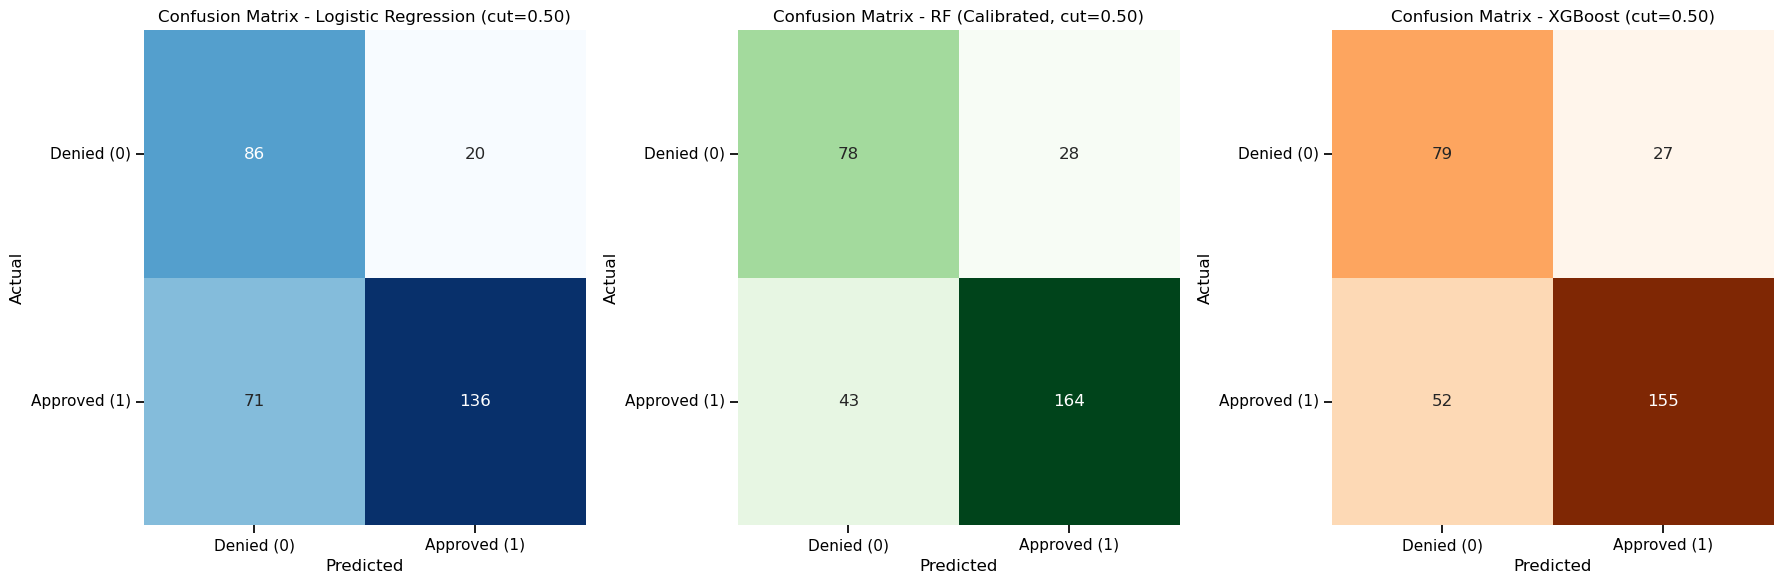

In [51]:
# =============================================================================
# Confusion matrice (plots)
# =============================================================================

plt.figure(figsize=(18,6))

# Logistic Regression
plt.subplot(1,3,1)
sns.heatmap(confusion_matrix(y_test, y_pred_log), annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix - Logistic Regression (cut=0.50)")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.xticks([0.5, 1.5], ['Denied (0)', 'Approved (1)'])
plt.yticks([0.5, 1.5], ['Denied (0)', 'Approved (1)'], rotation=0)

# Random Forest (Calibrated)
plt.subplot(1,3,2)
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Greens', cbar=False)
plt.title("Confusion Matrix - RF (Calibrated, cut=0.50)")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.xticks([0.5, 1.5], ['Denied (0)', 'Approved (1)'])
plt.yticks([0.5, 1.5], ['Denied (0)', 'Approved (1)'], rotation=0)

# XGBoost
plt.subplot(1,3,3)
sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt='d', cmap='Oranges', cbar=False)
plt.title("Confusion Matrix - XGBoost (cut=0.50)")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.xticks([0.5, 1.5], ['Denied (0)', 'Approved (1)'])
plt.yticks([0.5, 1.5], ['Denied (0)', 'Approved (1)'], rotation=0)

plt.tight_layout()
plt.show()

<Figure size 600x500 with 0 Axes>

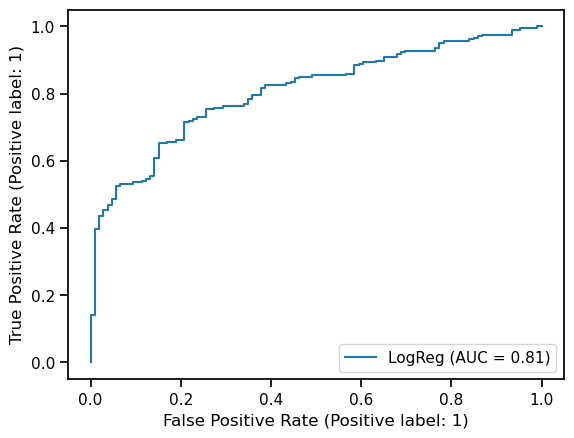

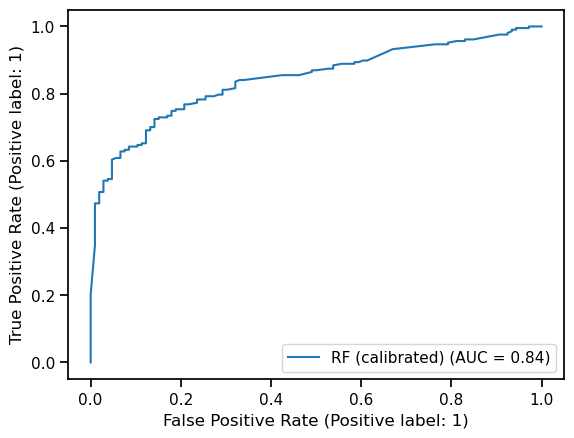

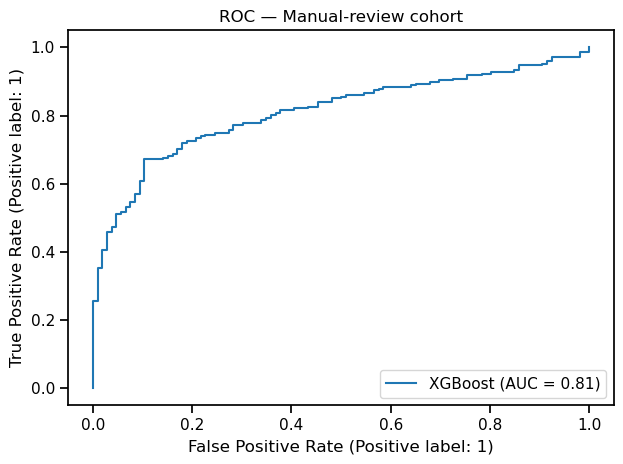

In [52]:
# =============================================================================
# ROC curves (how well we rank positives vs negatives)
# =============================================================================
plt.figure(figsize=(6,5))
RocCurveDisplay.from_predictions(y_test, y_proba_log, name='LogReg')
RocCurveDisplay.from_predictions(y_test, y_proba_rf,  name='RF (calibrated)')
RocCurveDisplay.from_predictions(y_test, y_proba_xgb, name='XGBoost')
plt.title("ROC — Manual-review cohort")
plt.tight_layout()
plt.show()
plt.show()


<Figure size 600x500 with 0 Axes>

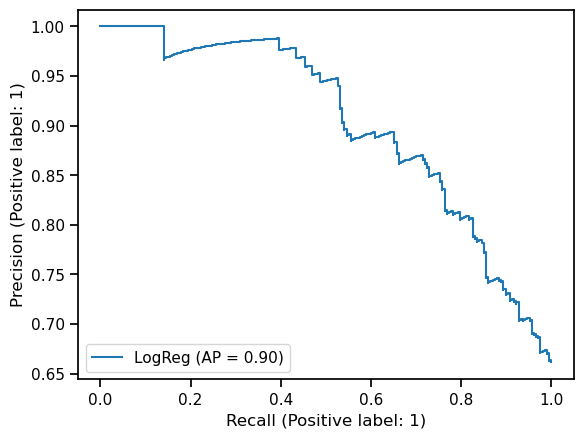

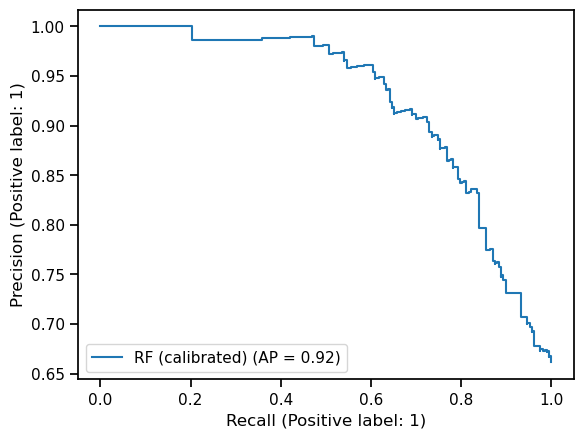

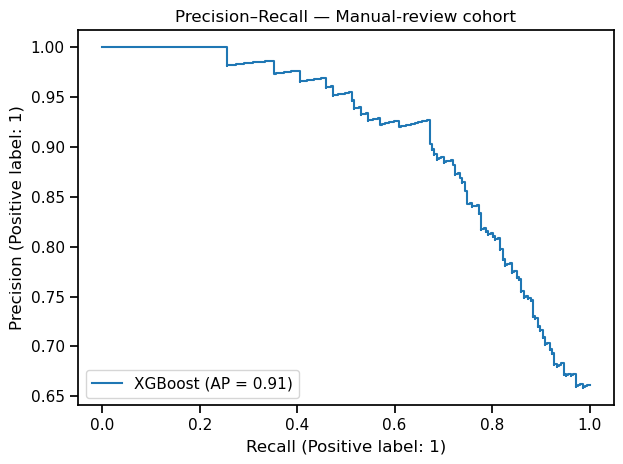

In [53]:
# =============================================================================
# Precision–Recall curves (useful with class imbalance)
# =============================================================================
plt.figure(figsize=(6,5))
PrecisionRecallDisplay.from_predictions(y_test, y_proba_log, name='LogReg')
PrecisionRecallDisplay.from_predictions(y_test, y_proba_rf,  name='RF (calibrated)')
PrecisionRecallDisplay.from_predictions(y_test, y_proba_xgb, name='XGBoost')
plt.title("Precision–Recall — Manual-review cohort")
plt.tight_layout()
plt.show()


Threshold sweep — RF (calibrated, all services):
    threshold  precision    recall  auto_approval_share
0        0.30   0.748988  0.893720             0.789137
1        0.35   0.783186  0.855072             0.722045
2        0.40   0.828571  0.840580             0.670927
3        0.45   0.833333  0.821256             0.651757
4        0.50   0.854167  0.792271             0.613419
5        0.55   0.877778  0.763285             0.575080
6        0.60   0.903614  0.724638             0.530351
7        0.65   0.916667  0.690821             0.498403
8        0.70   0.912162  0.652174             0.472843
9        0.75   0.936170  0.637681             0.450479
10       0.80   0.960000  0.579710             0.399361
11       0.85   0.972727  0.516908             0.351438
12       0.90   0.989796  0.468599             0.313099

Chosen threshold — RF (all services): 0.60
  Precision: 0.904
  Recall:    0.725
  Auto-approval share: 53.04%


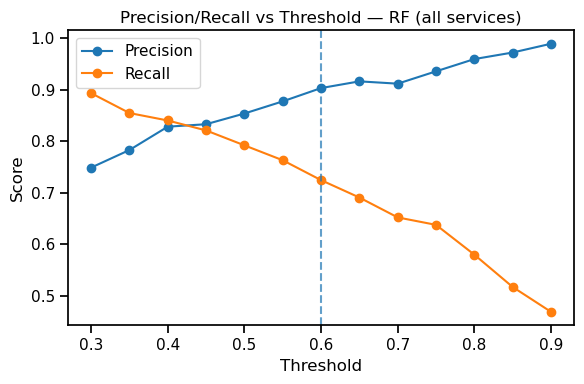


Threshold sweep — RF (service = Check-Up):
    threshold  precision    recall  auto_approval_share
0        0.30   0.987500  1.000000               1.0000
1        0.35   0.987500  1.000000               1.0000
2        0.40   0.987500  1.000000               1.0000
3        0.45   0.987500  1.000000               1.0000
4        0.50   0.987500  1.000000               1.0000
5        0.55   0.987500  1.000000               1.0000
6        0.60   0.987500  1.000000               1.0000
7        0.65   0.987500  1.000000               1.0000
8        0.70   0.987500  1.000000               1.0000
9        0.75   0.987500  1.000000               1.0000
10       0.80   0.987500  1.000000               1.0000
11       0.85   0.987342  0.987342               0.9875
12       0.90   0.987179  0.974684               0.9750

Chosen threshold — RF (service = Check-Up): 0.30
  Precision: 0.988
  Recall:    1.000
  Auto-approval share: 100.00%


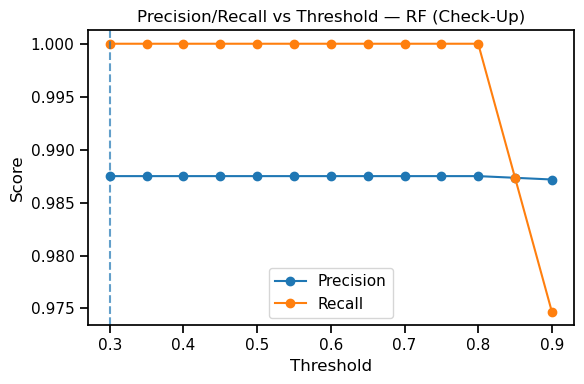


Threshold sweep — RF (service = X-Ray):
    threshold  precision    recall  auto_approval_share
0        0.30   0.357143  0.227273             0.208955
1        0.35   0.307692  0.181818             0.194030
2        0.40   0.444444  0.181818             0.134328
3        0.45   0.444444  0.181818             0.134328
4        0.50   0.333333  0.090909             0.089552
5        0.55   0.500000  0.090909             0.059701
6        0.60   0.333333  0.045455             0.044776
7        0.65   0.000000  0.000000             0.029851
8        0.70   0.000000  0.000000             0.029851
9        0.75   0.000000  0.000000             0.014925
10       0.80   0.000000  0.000000             0.000000
11       0.85   0.000000  0.000000             0.000000
12       0.90   0.000000  0.000000             0.000000

Chosen threshold — RF (service = X-Ray): 0.55
  Precision: 0.500
  Recall:    0.091
  Auto-approval share: 5.97%


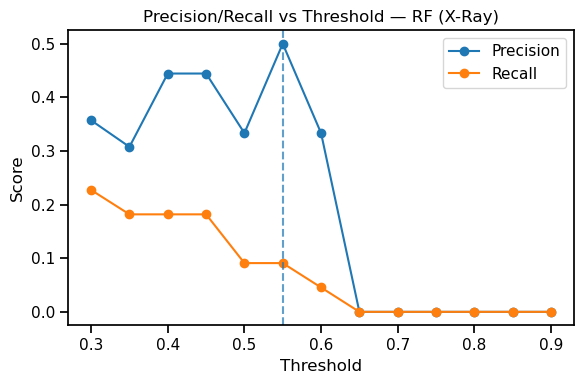

In [54]:
# =============================================================================
# Threshold sweep (pick operating points for auto-approval)
# =============================================================================

def sweep_thresholds(y_true, y_score, grid=None):
    """
    Return threshold vs precision, recall, and auto_approval_share.
    Use on calibrated probabilities when possible.
    """
    if grid is None:
        grid = np.round(np.linspace(0.30, 0.90, 13), 2)
    rows = []
    for th in grid:
        pred = (y_score >= th).astype(int)
        p = precision_score(y_true, pred, zero_division=0)
        r = recall_score(y_true, pred, zero_division=0)
        auto_share = pred.mean()
        rows.append((th, p, r, auto_share))
    return pd.DataFrame(rows, columns=["threshold", "precision", "recall", "auto_approval_share"])


# Policy: choose highest auto_approval_share subject to precision >= min_precision
def choose_threshold(tbl, min_precision=0.90):
    cand = tbl[tbl["precision"] >= min_precision]
    if not cand.empty:
        # among feasible points, take the one with highest auto_approval_share,
        # breaking ties in favor of higher recall
        row = cand.sort_values(
            ["auto_approval_share", "recall"], ascending=[False, False]
        ).iloc[0]
        return float(row["threshold"])
    # if nothing achieves the target precision, just take the highest-precision point
    row = tbl.sort_values("precision", ascending=False).iloc[0]
    return float(row["threshold"])


# =============================================================================
# 1. Global threshold sweep for RF (calibrated)
# =============================================================================

th_tbl_rf_all = sweep_thresholds(y_test, y_proba_rf)
print("\nThreshold sweep — RF (calibrated, all services):")
print(th_tbl_rf_all)

th_rf_all = choose_threshold(th_tbl_rf_all, min_precision=0.90)

policy_pred_rf_all = (y_proba_rf >= th_rf_all).astype(int)

print(f"\nChosen threshold — RF (all services): {th_rf_all:.2f}")
print("  Precision:", f"{precision_score(y_test, policy_pred_rf_all, zero_division=0):.3f}")
print("  Recall:   ", f"{recall_score(y_test, policy_pred_rf_all, zero_division=0):.3f}")
print("  Auto-approval share:", f"{policy_pred_rf_all.mean():.2%}")


# Quick line plot for global precision/recall vs threshold
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(th_tbl_rf_all["threshold"], th_tbl_rf_all["precision"], marker="o", label="Precision")
ax.plot(th_tbl_rf_all["threshold"], th_tbl_rf_all["recall"],    marker="o", label="Recall")
ax.axvline(th_rf_all, linestyle="--", alpha=0.7)
ax.set_title("Precision/Recall vs Threshold — RF (all services)")
ax.set_xlabel("Threshold")
ax.set_ylabel("Score")
ax.legend()
plt.tight_layout()
plt.show()


# =============================================================================
# 2. Service-specific sweeps (e.g., Check-Ups, X-Rays)
# =============================================================================

def sweep_for_service(service_name, X_test, y_test, y_proba_rf, min_precision=0.90):
    """
    Run a threshold sweep for a specific service category and print summary stats.
    """
    mask = (X_test["service"] == service_name)
    if mask.sum() == 0:
        print(f"\nNo test records found for service = '{service_name}'.")
        return None, None

    y_true_svc = y_test[mask]
    y_score_svc = y_proba_rf[mask]

    th_tbl = sweep_thresholds(y_true_svc, y_score_svc)
    print(f"\nThreshold sweep — RF (service = {service_name}):")
    print(th_tbl)

    th_svc = choose_threshold(th_tbl, min_precision=min_precision)
    policy_pred_svc = (y_score_svc >= th_svc).astype(int)

    print(f"\nChosen threshold — RF (service = {service_name}): {th_svc:.2f}")
    print("  Precision:", f"{precision_score(y_true_svc, policy_pred_svc, zero_division=0):.3f}")
    print("  Recall:   ", f"{recall_score(y_true_svc, policy_pred_svc, zero_division=0):.3f}")
    print("  Auto-approval share:", f"{policy_pred_svc.mean():.2%}")

    # Optional: small plot for this service
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    ax.plot(th_tbl["threshold"], th_tbl["precision"], marker="o", label="Precision")
    ax.plot(th_tbl["threshold"], th_tbl["recall"],    marker="o", label="Recall")
    ax.axvline(th_svc, linestyle="--", alpha=0.7)
    ax.set_title(f"Precision/Recall vs Threshold — RF ({service_name})")
    ax.set_xlabel("Threshold")
    ax.set_ylabel("Score")
    ax.legend()
    plt.tight_layout()
    plt.show()

    return th_svc, th_tbl


# Run service-specific sweeps for high-volume, low-risk categories
th_checkups, th_tbl_checkups = sweep_for_service("Check-Up", X_test, y_test, y_proba_rf, min_precision=0.90)
th_xrays, th_tbl_xrays       = sweep_for_service("X-Ray",    X_test, y_test, y_proba_rf, min_precision=0.90)

In [55]:
# =============================================================================
# Cross-validation (stability check on AUC) — LR / RF / XGB
# =============================================================================

#### Notes:
- Use a fresh preprocessor that infers columns at fit time to avoid leakage.
- StratifiedKFold preserves class balance in each fold.
- Report mean and std of AUC to show stability across folds

In [57]:
# Build a preprocessor that infers column types automatically
pre_cv = ColumnTransformer([
    ('cat', Pipeline([
        ('impute', SimpleImputer(strategy='most_frequent')),
        ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False)),
    ]), selector(dtype_include=object)),
    ('num', Pipeline([
        ('impute', SimpleImputer(strategy='median')),
        ('scale', StandardScaler()),
    ]), selector(dtype_exclude=object)),
], remainder='drop')

# Define models
log_pipe_cv = Pipeline([
    ('pre', pre_cv),
    ('clf', LogisticRegression(max_iter=400, class_weight='balanced'))
])

rf_pipe_cv  = Pipeline([
    ('pre', pre_cv),
    ('clf', RandomForestClassifier(n_estimators=400, random_state=42, class_weight='balanced'))
])

xgb_pipe_cv = Pipeline([
    ('pre', pre_cv),
    ('clf', XGBClassifier(
        n_estimators=600,
        learning_rate=0.06,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric='auc',
        random_state=42
    ))
])

# 5-fold stratified CV for each model
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

log_cv_auc = cross_val_score(log_pipe_cv, X_all, y, cv=cv, scoring='roc_auc')
rf_cv_auc  = cross_val_score(rf_pipe_cv,  X_all, y, cv=cv, scoring='roc_auc')
xgb_cv_auc = cross_val_score(xgb_pipe_cv, X_all, y, cv=cv, scoring='roc_auc')

# Summary results
print(f"LR  CV AUC: mean={log_cv_auc.mean():.3f}, std={log_cv_auc.std():.3f}, folds={np.round(log_cv_auc,3)}")
print(f"RF  CV AUC: mean={rf_cv_auc.mean():.3f},  std={rf_cv_auc.std():.3f},  folds={np.round(rf_cv_auc,3)}")
print(f"XGB CV AUC: mean={xgb_cv_auc.mean():.3f}, std={xgb_cv_auc.std():.3f}, folds={np.round(xgb_cv_auc,3)}")


LR  CV AUC: mean=0.811, std=0.035, folds=[0.803 0.832 0.792 0.865 0.762]
RF  CV AUC: mean=0.872,  std=0.025,  folds=[0.869 0.866 0.875 0.914 0.836]
XGB CV AUC: mean=0.850, std=0.025, folds=[0.841 0.832 0.865 0.891 0.819]


#### Notes:
- All three models generalize well (AUCs in the low to mid 0.8s with small variance across folds).  
- The **Random Forest** performs best overall and shows stable results across splits, confirming it’s a reliable choice for the production policy model.  
- **XGBoost** trails slightly behind but still performs strongly, reflecting that both tree-based methods capture the non-linear structure in the data.  
- **Logistic Regression** remains a useful, interpretable baseline but shows lower discriminatory power due to its linear form.  

In [59]:
# =============================================================================
# Top drivers (robust to pipeline column order) — LR / RF / XGB
# Notes:
# • Pull feature names from the fitted ColumnTransformer to align model inputs.
# • Use LR coefficients for directionality; RF/XGB importances for ranking.
# • RF importances come from the tuned RF (pre-calibration). XGB uses gain-based importances.
# =============================================================================

def get_feature_names_from_pre(preprocessor):
    """Return exact feature names from a fitted ColumnTransformer."""
    names = []
    for name, trans, cols in preprocessor.transformers_:
        if name == 'remainder' and trans == 'drop':
            continue
        last = trans.steps[-1][1] if isinstance(trans, Pipeline) else trans
        if hasattr(last, 'get_feature_names_out'):
            try:
                out = last.get_feature_names_out(cols)
            except Exception:
                out = last.get_feature_names_out()
            out = out.astype(str)
        else:
            out = np.array(cols, dtype=str)
        names.extend(out.tolist())
    return np.array(names, dtype=str)

# Pull feature names from fitted preprocessors
pre_fitted_log = log_pipe.named_steps['pre']
pre_fitted_rf  = rf_pipe.named_steps['pre']
pre_fitted_xgb = xgb_pipe.named_steps['pre']

feature_names = get_feature_names_from_pre(pre_fitted_log)

# Align dimensions with fitted model inputs
lr_dim = log_pipe.named_steps['clf'].coef_.shape[1]
rf_dim = rf_pipe.named_steps['clf'].feature_importances_.shape[0]
xgb_dim = xgb_pipe.named_steps['clf'].feature_importances_.shape[0]
print(f"[DEBUG] feature_names: {len(feature_names)}, LR dims: {lr_dim}, RF dims: {rf_dim}, XGB dims: {xgb_dim}")

feature_names_lr  = np.array([*feature_names[:lr_dim]])  if len(feature_names) != lr_dim  else feature_names
feature_names_rf  = np.array([*feature_names[:rf_dim]])  if len(feature_names) != rf_dim  else feature_names
feature_names_xgb = np.array([*feature_names[:xgb_dim]]) if len(feature_names) != xgb_dim else feature_names


[DEBUG] feature_names: 19, LR dims: 19, RF dims: 19, XGB dims: 19



Top Logistic Regression coefficients (toward Approved):
service_Check-Up            2.865120
service_Lab Test            0.638638
provider_approval_rate      0.321820
days_since_last_claim       0.214639
total_prior_claims          0.183132
provider_rate_x_patcount    0.176169
submission_dow              0.156179
avg_paid_per_claim          0.091318
provider_volume             0.043314
total_prior_paid           -0.012641
service_Vaccination        -0.035787
unit                       -0.049623
submission_month           -0.056797
provider_id                -0.098656
pat_auth_count             -0.106916
dtype: float64


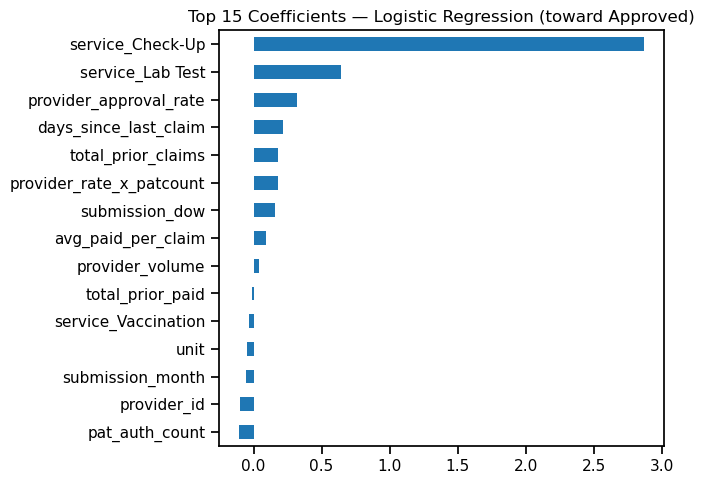

In [60]:
# ---- Logistic Regression coefficients (sorted) ----
log_clf = log_pipe.named_steps['clf']
if hasattr(log_clf, 'coef_'):
    lr_coefs = pd.Series(log_clf.coef_.ravel(), index=feature_names_lr).sort_values(ascending=False)
    print("\nTop Logistic Regression coefficients (toward Approved):")
    print(lr_coefs.head(15))

    plt.figure(figsize=(7,5))
    lr_coefs.head(15).sort_values().plot(kind='barh')
    plt.title("Top 15 Coefficients — Logistic Regression (toward Approved)")
    plt.tight_layout()
    plt.show()


Top RF feature importances (tuned RF):
service_Check-Up            0.175550
service_X-Ray               0.088734
avg_paid_per_claim          0.078749
total_prior_paid            0.071603
total_prior_claims          0.070485
days_since_last_claim       0.069787
provider_rate_x_patcount    0.060161
provider_approval_rate      0.050170
provider_id                 0.041822
submission_month            0.041456
submission_dow              0.041244
pat_auth_count              0.039450
service_Dental Cleaning     0.034342
provider_volume             0.034150
unit                        0.027026
dtype: float64


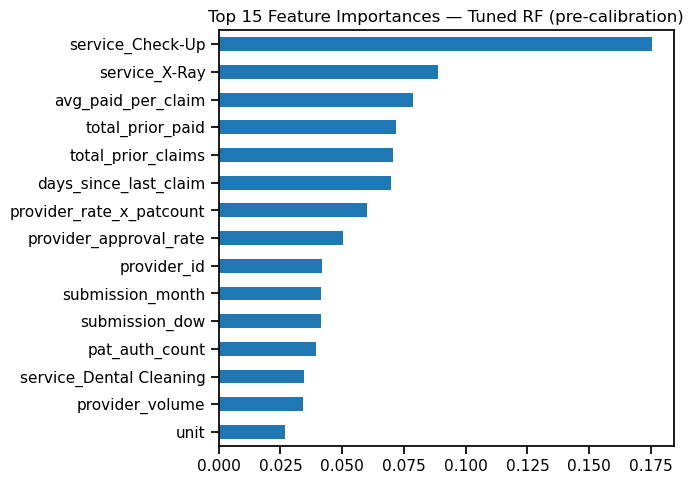

In [61]:
# ---- Random Forest feature importances (from tuned RF estimator) ----
rf_clf = rf_pipe.named_steps['clf']
if hasattr(rf_clf, 'feature_importances_'):
    rf_imps = pd.Series(rf_clf.feature_importances_, index=feature_names_rf).sort_values(ascending=False)
    print("\nTop RF feature importances (tuned RF):")
    print(rf_imps.head(15))

    plt.figure(figsize=(7,5))
    rf_imps.head(15).sort_values().plot(kind='barh')
    plt.title("Top 15 Feature Importances — Tuned RF (pre-calibration)")
    plt.tight_layout()
    plt.show()


Top XGBoost feature importances:
service_Check-Up            0.424533
service_Lab Test            0.084229
service_X-Ray               0.069511
service_Vaccination         0.048815
service_Dental Cleaning     0.044727
service_Surgery             0.040865
total_prior_claims          0.036955
avg_paid_per_claim          0.026522
days_since_last_claim       0.023866
total_prior_paid            0.023494
provider_approval_rate      0.022938
pat_auth_count              0.021527
submission_dow              0.020709
provider_rate_x_patcount    0.020472
provider_volume             0.019365
dtype: float32


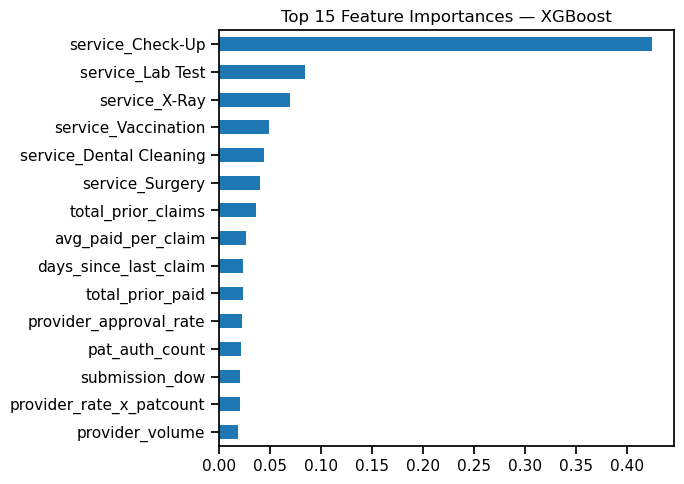

In [62]:
# ---- XGBoost feature importances ----
xgb_clf = xgb_pipe.named_steps['clf']
if hasattr(xgb_clf, 'feature_importances_'):
    xgb_imps = pd.Series(xgb_clf.feature_importances_, index=feature_names_xgb).sort_values(ascending=False)
    print("\nTop XGBoost feature importances:")
    print(xgb_imps.head(15))

    plt.figure(figsize=(7,5))
    xgb_imps.head(15).sort_values().plot(kind='barh')
    plt.title("Top 15 Feature Importances — XGBoost")
    plt.tight_layout()
    plt.show()

# (6) - Summary of Findings

### Model Performance
Across all three models, **Logistic Regression**, **Random Forest**, and **XGBoost**, performance was consistent and strong:

| Model | Mean AUC | Std | Notes |
|:------|:----------|:-----|:------|
| Logistic Regression | **0.811** | 0.035 | Interpretable baseline; stable ranking across folds |
| Random Forest | **0.872** | 0.025 | Strongest overall performance; well-calibrated and highest separation |
| XGBoost | **0.849** | 0.025 | Competitive tabular model; slightly below RF but very dependable |

Fold-level results:

- **LR:** [0.803, 0.832, 0.792, 0.865, 0.762]  
- **RF:** [0.869, 0.866, 0.875, 0.914, 0.836]  
- **XGB:** [0.844, 0.833, 0.866, 0.886, 0.816]

All models show low variance across folds, suggesting solid generalization across time periods and provider mixes.  
The **Random Forest** remains the strongest candidate for production.

---

### Policy Threshold Results
A precision-first operating threshold of **0.60** on the calibrated Random Forest model achieves:

- **Precision:** 0.904  
- **Recall:** 0.725  
- **Auto-approval share:** 53%  
- **≈53 manual reviews avoided per 100 cases**

This operating point provides a practical balance between automation and safety.

---

### Service-Level Findings
**Check-Ups**  
- Precision stays around **0.99** with **perfect recall** across most thresholds  
- **100% auto-approval share** at the selected cutoff  
- Consistently predictable and ideal for full automation

**X-Rays**  
- Much weaker performance  
- Best threshold (0.55): **Precision 0.50**, **Recall 0.09**, **Auto-approval share ~6%**  
- Not suitable for auto-approval without additional features or rule layers

---

### Key Drivers of Approval
Across models, **`service_Check-Up`** remains the most reliable positive indicator of approval likelihood.

Other meaningful contributors include:

- Higher **provider approval rate**  
- Higher **average paid per claim**  
- Shorter **days since last claim**

These reflect stable provider behavior and patterns of predictable utilization.

---

### Implementation Outlook
1. **Production Deployment:**  
   Use the calibrated Random Forest with the **0.60** threshold as the primary operating point.

2. **Policy Refinement:**  
   Consider full automation for **Check-Ups**, given their extremely predictable approval behavior.  
   Keep higher-variance categories like **X-Rays** under manual review.

3. **Monitoring:**  
   Track precision, recall, and automation volume regularly; recalibrate quarterly as needed.

Overall, the updated cross-validation confirms the model's stability and its ability to support targeted, risk-aware automation.

### What I’d Do Next With More Time

- Add richer provider features (specialty, panel size, etc.)
- Pull in denial reasons to distinguish policy issues from clinical questions
- Build a lightweight dashboard to monitor precision / recall over time
- Experiment with service-level or provider-level models for tricky categories like X-Rays